# Name Classfication

# Preparing the Data

In [ ]:
from io import open
import glob
import os

In [ ]:
def findFiles(path):
  return glob.glob(path)

In [ ]:
for f in findFiles('./data/*.txt'):
  print(f)

./data/Japanese.txt
./data/Portuguese.txt
./data/English.txt
./data/Chinese.txt
./data/Dutch.txt
./data/Polish.txt
./data/Spanish.txt
./data/Czech.txt
./data/Arabic.txt
./data/Russian.txt
./data/French.txt
./data/Vietnamese.txt
./data/German.txt
./data/Irish.txt
./data/Greek.txt
./data/Korean.txt
./data/Italian.txt
./data/Scottish.txt


In [ ]:
import unicodedata
import string

In [ ]:
all_letters = string.ascii_letters + ".,;'"
print(all_letters)
n_letters = len(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'


In [ ]:
# Turn a unicode string to plain ASCII
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
  )

In [ ]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [ ]:
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

In [ ]:
for filename in findFiles('./data/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

In [ ]:
n_categories = len(all_categories)
n_categories

18

# Turning Names into Tensors

In [ ]:
import torch

extra 1 dimension is because PyTorch assumes everything is in <br>
*batches torch.zeros(1, n_letter)*

In [ ]:
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor


def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

In [ ]:
lineToTensor('Ankit')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

# Creating the Network

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)
    hidden_tensor = self.i2h(combined)
    output = self.h2o(hidden_tensor)
    output = self.softmax(output)
    return output, hidden_tensor

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input_tensor = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input_tensor[0], hidden)
print(output)

tensor([[-2.8955, -2.9640, -2.9978, -2.8199, -2.8283, -2.7744, -2.8051, -2.9084,
         -2.9709, -2.8932, -2.9472, -2.8904, -2.8775, -2.9323, -2.9041, -2.9133,
         -2.8390, -2.8966]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
output.topk(1)

torch.return_types.topk(
values=tensor([[-2.7744]], grad_fn=<TopkBackward0>),
indices=tensor([[5]]))

In [ ]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 5)


# Training

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Hautum
category = Vietnamese / line = Ly
category = Italian / line = Basso
category = French / line = Royer
category = Italian / line = Abatantuono
category = Spanish / line = Sepulveda
category = French / line = Lyon
category = Spanish / line = Delgado
category = Irish / line = O'Donnell
category = Portuguese / line = Machado


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.9609 Niftrik / Polish ✗ (Dutch)
10000 10% (0m 12s) 1.8496 Ieyasu / Japanese ✓
15000 15% (0m 19s) 2.3694 Watt / German ✗ (Scottish)
20000 20% (0m 25s) 0.3932 Jon / Korean ✓
25000 25% (0m 31s) 2.3433 Boyle / English ✗ (Scottish)
30000 30% (0m 38s) 0.0703 Wawrzaszek / Polish ✓
35000 35% (0m 44s) 0.3160 Quang / Vietnamese ✓
40000 40% (0m 50s) 1.7902 Franco / Italian ✗ (Portuguese)
45000 45% (0m 56s) 2.4281 Kava / Czech ✗ (Polish)
50000 50% (1m 3s) 0.3180 Vasquez / Spanish ✓
55000 55% (1m 9s) 3.9196 Reyes / Dutch ✗ (Spanish)
60000 60% (1m 15s) 0.0950 Darkshevich / Russian ✓
65000 65% (1m 21s) 2.3469 Salazar / Arabic ✗ (Portuguese)
70000 70% (1m 27s) 0.1800 Kozlow / Polish ✓
75000 75% (1m 33s) 0.7554 Seok / Korean ✓
80000 80% (1m 40s) 3.0424 Gouveia / Spanish ✗ (Portuguese)
85000 85% (1m 46s) 0.3580 Ortega / Spanish ✓
90000 90% (1m 53s) 2.1802 Giersig / Scottish ✗ (Czech)
95000 95% (1m 59s) 0.8388 Tadhgan / Irish ✓
100000 100% (2m 5s) 0.0931 Vuong / Vietnamese ✓


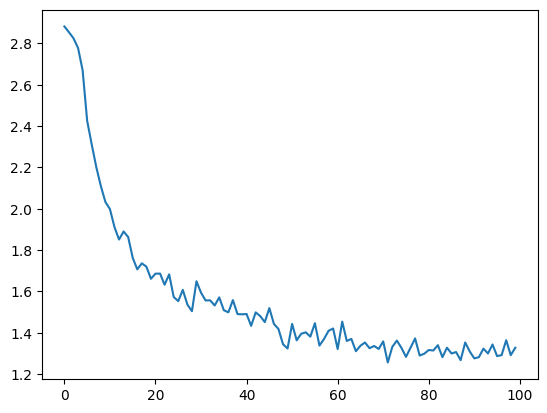

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluation

<ipython-input-57-ad3198427f7e>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-57-ad3198427f7e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


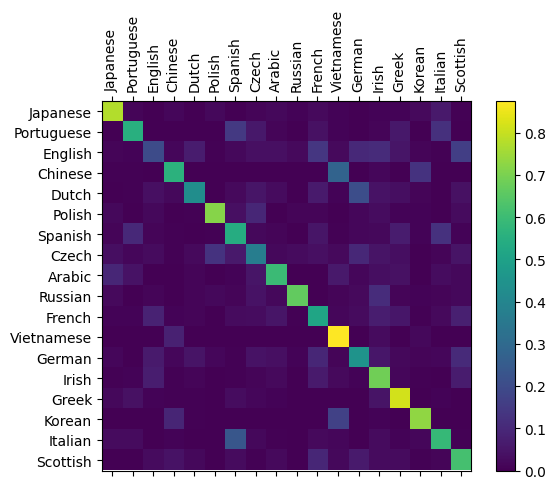

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [ ]:
predict('Karen')


> Karen
(-0.38) Dutch
(-1.97) German
(-2.99) French
